In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install torchsummary

In [4]:
import torch.nn as nn

class Net_BN(nn.Module):
    def __init__(self):
        super(Net_BN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), bias=False, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), bias=False, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, kernel_size=(3, 3), bias=False, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), bias=False, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), bias=False, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, kernel_size=(3, 3), bias=False, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), bias=False, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), bias=False, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Sequential(nn.AvgPool2d(kernel_size=6)),
            nn.Conv2d(16, 10, kernel_size=(1, 1), bias=False)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net_BN().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             256
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,304
      BatchNorm2d-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 16,

In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((32, 32)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((32, 32)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


In [7]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [9]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

dataiter = iter(train_loader)
images, labels = next(dataiter)

Files already downloaded and verified
Files already downloaded and verified


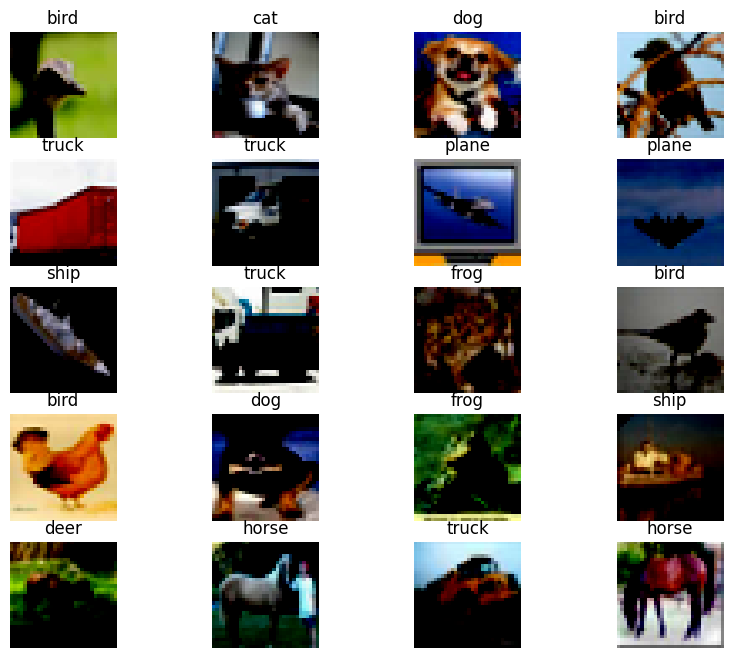

In [10]:
figure = plt.figure(figsize=(10,8))
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(5, 4, index)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy(), (1, 2, 0)))
    plt.title(classes[labels[index].item()])


In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.14, momentum=0.90)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Epoch 1


Loss=1.0957615375518799 Batch_id=390 Accuracy=40.64: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]



Test set: Average loss: 1.4675, Accuracy: 4860/10000 (48.60%)

Epoch 2


Loss=0.9745289087295532 Batch_id=390 Accuracy=58.24: 100%|██████████| 391/391 [00:20<00:00, 18.87it/s]



Test set: Average loss: 1.3663, Accuracy: 5108/10000 (51.08%)

Epoch 3


Loss=0.9281660318374634 Batch_id=390 Accuracy=64.50: 100%|██████████| 391/391 [00:20<00:00, 18.69it/s]



Test set: Average loss: 1.0063, Accuracy: 6413/10000 (64.13%)

Epoch 4


Loss=0.7361658811569214 Batch_id=390 Accuracy=68.45: 100%|██████████| 391/391 [00:19<00:00, 20.04it/s]



Test set: Average loss: 0.9527, Accuracy: 6682/10000 (66.82%)

Epoch 5


Loss=0.9839907884597778 Batch_id=390 Accuracy=71.15: 100%|██████████| 391/391 [00:19<00:00, 19.57it/s]



Test set: Average loss: 0.9976, Accuracy: 6656/10000 (66.56%)

Epoch 6


Loss=0.8241330981254578 Batch_id=390 Accuracy=75.55: 100%|██████████| 391/391 [00:21<00:00, 18.36it/s]



Test set: Average loss: 0.7426, Accuracy: 7414/10000 (74.14%)

Epoch 7


Loss=0.6766558885574341 Batch_id=390 Accuracy=76.32: 100%|██████████| 391/391 [00:20<00:00, 18.65it/s]



Test set: Average loss: 0.7373, Accuracy: 7433/10000 (74.33%)

Epoch 8


Loss=0.5615554451942444 Batch_id=390 Accuracy=76.93: 100%|██████████| 391/391 [00:19<00:00, 19.61it/s]



Test set: Average loss: 0.7230, Accuracy: 7465/10000 (74.65%)

Epoch 9


Loss=0.603932797908783 Batch_id=390 Accuracy=77.04: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]



Test set: Average loss: 0.7186, Accuracy: 7513/10000 (75.13%)

Epoch 10


Loss=0.5822582244873047 Batch_id=390 Accuracy=77.57: 100%|██████████| 391/391 [00:20<00:00, 18.94it/s]



Test set: Average loss: 0.7129, Accuracy: 7513/10000 (75.13%)

Epoch 11


Loss=0.7182044982910156 Batch_id=390 Accuracy=78.24: 100%|██████████| 391/391 [00:21<00:00, 18.60it/s]



Test set: Average loss: 0.7049, Accuracy: 7560/10000 (75.60%)

Epoch 12


Loss=0.7730027437210083 Batch_id=390 Accuracy=78.34: 100%|██████████| 391/391 [00:19<00:00, 19.60it/s]



Test set: Average loss: 0.7036, Accuracy: 7569/10000 (75.69%)

Epoch 13


Loss=0.7241803407669067 Batch_id=390 Accuracy=78.52: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]



Test set: Average loss: 0.7049, Accuracy: 7567/10000 (75.67%)

Epoch 14


Loss=0.5266481637954712 Batch_id=390 Accuracy=78.45: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]



Test set: Average loss: 0.7042, Accuracy: 7570/10000 (75.70%)

Epoch 15


Loss=0.5673394203186035 Batch_id=390 Accuracy=78.42: 100%|██████████| 391/391 [00:20<00:00, 18.92it/s]



Test set: Average loss: 0.7034, Accuracy: 7557/10000 (75.57%)

Epoch 16


Loss=0.6128227114677429 Batch_id=390 Accuracy=78.58: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]



Test set: Average loss: 0.7042, Accuracy: 7570/10000 (75.70%)

Epoch 17


Loss=0.6834800839424133 Batch_id=390 Accuracy=78.66: 100%|██████████| 391/391 [00:19<00:00, 19.90it/s]



Test set: Average loss: 0.7023, Accuracy: 7573/10000 (75.73%)

Epoch 18


Loss=0.5396294593811035 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s]



Test set: Average loss: 0.7047, Accuracy: 7554/10000 (75.54%)

Epoch 19


Loss=0.6840863227844238 Batch_id=390 Accuracy=78.74: 100%|██████████| 391/391 [00:20<00:00, 18.67it/s]



Test set: Average loss: 0.7032, Accuracy: 7573/10000 (75.73%)

Epoch 20


Loss=0.5889257192611694 Batch_id=390 Accuracy=78.71: 100%|██████████| 391/391 [00:19<00:00, 19.58it/s]



Test set: Average loss: 0.7028, Accuracy: 7585/10000 (75.85%)



Text(0.5, 1.0, 'Test Accuracy')

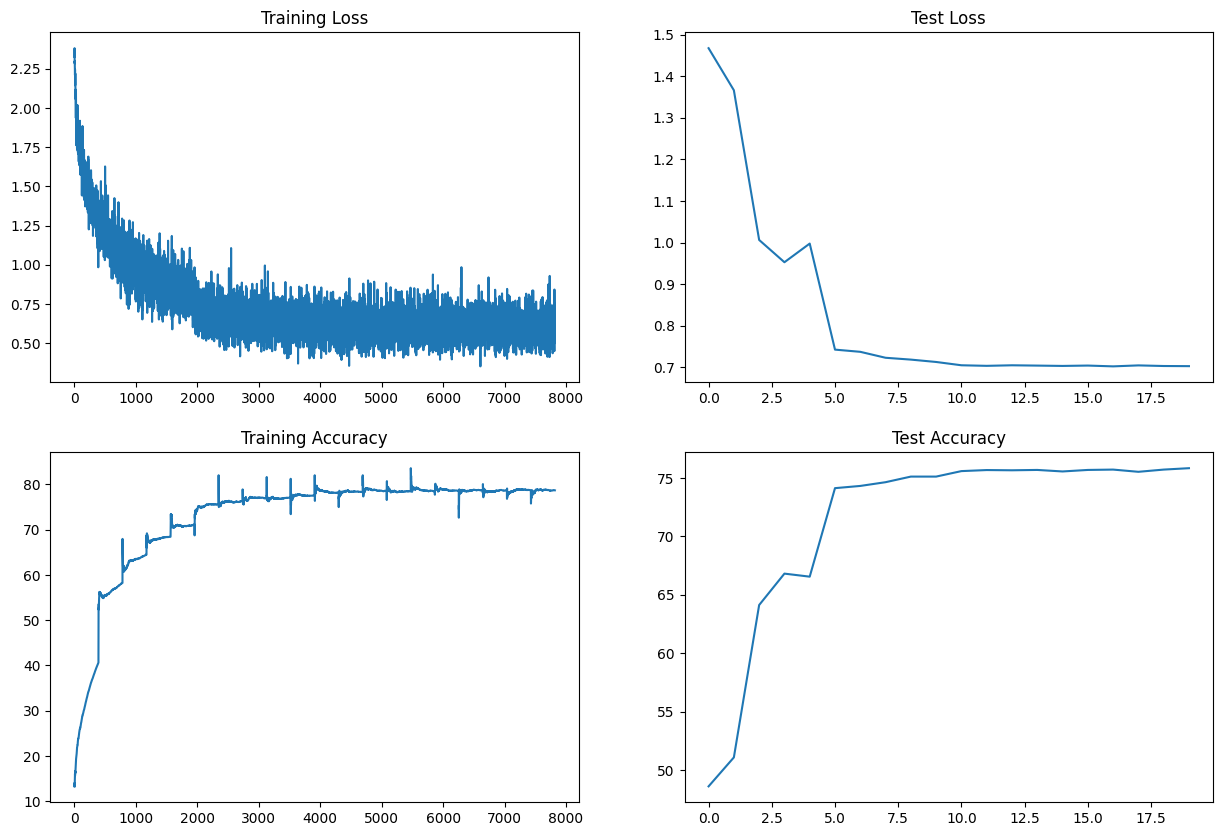

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(torch.tensor(train_losses).cpu().detach().numpy())
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [14]:
error_images = []
error_target = []
error_predicted = []
count = 0

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  for i in range (0, 127):
    if (pred[i].cpu().numpy()[0] != target[i].cpu().numpy()):
      error_images.append(data[i])
      error_target.append(target[i].cpu().numpy())
      error_predicted.append(pred[i].cpu().numpy()[0])

      count = count + 1

      if count > 10:
        break

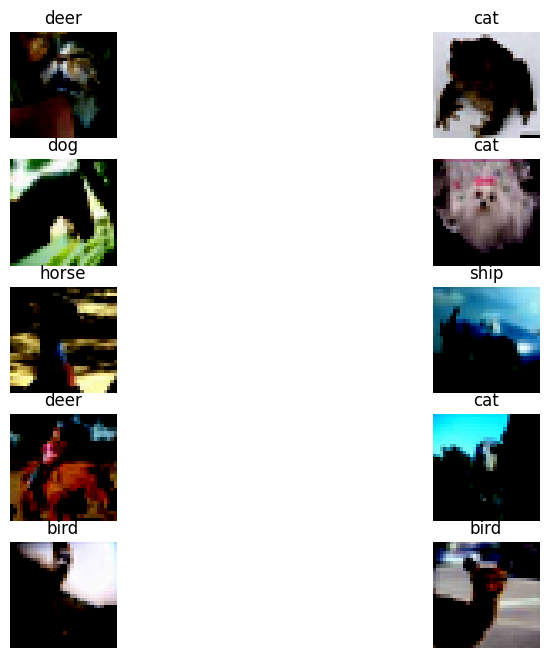

In [15]:
figure = plt.figure(figsize=(10, 8))
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(5, 2, index)
    plt.axis('off')
    plt.imshow(np.transpose(error_images[index].cpu().numpy(), (1, 2, 0)))
    plt.title(classes[error_predicted[index].item()])
